In [178]:
import qiskit
#import matplotlib.pyplot as plt


Bernstein-Vazirani Algorithm

In [179]:
from qiskit import *
from qiskit_aer import *

In [180]:
from qiskit.visualization import plot_histogram as pl1

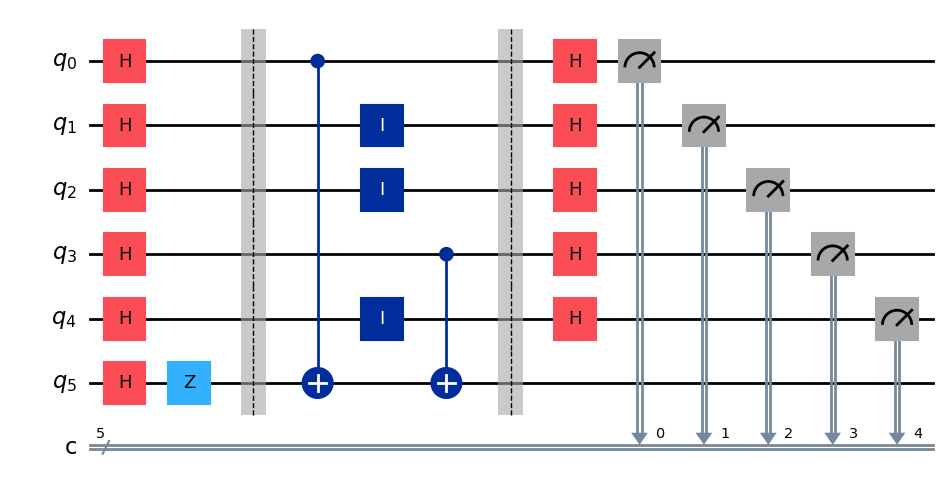

In [181]:
n = 5 
s = '01001'

bv_circuit = QuantumCircuit(n+1, n)
bv_circuit.h(n)
bv_circuit.z(n)

# Apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Apply barrier
bv_circuit.barrier()

# Apply the inner-product oracle
s = s[::-1] 
for q in range(n):
    if s[q] == '0':
        bv_circuit.id(q)
    else:
        bv_circuit.cx(q, n)

# Apply barrier
bv_circuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Measurement
for i in range(n):
    bv_circuit.measure(i, i)

bv_circuit.draw('mpl')



In [182]:
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(bv_circuit, simulator)
job = simulator.run(compiled_circuit, shots=1024)
result = job.result()
counts = result.get_counts(compiled_circuit)



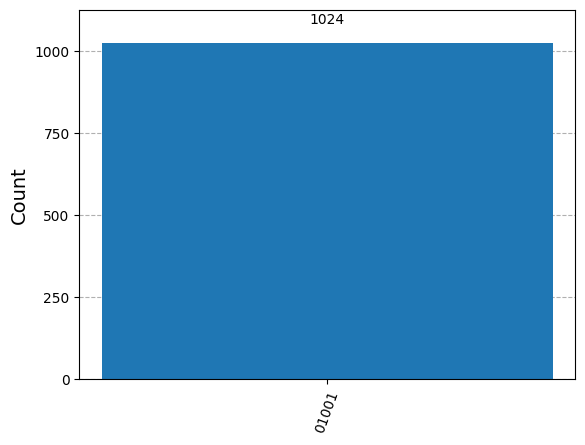

In [183]:
pl1([counts])

Deutsch Josza Algorithm

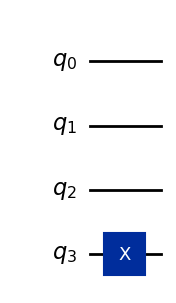

In [184]:
import numpy as np
from qiskit.primitives import Sampler, Estimator

n = 3

const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

const_oracle.draw('mpl')



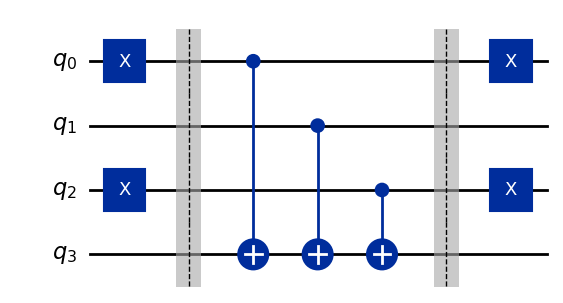

In [185]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw('mpl')

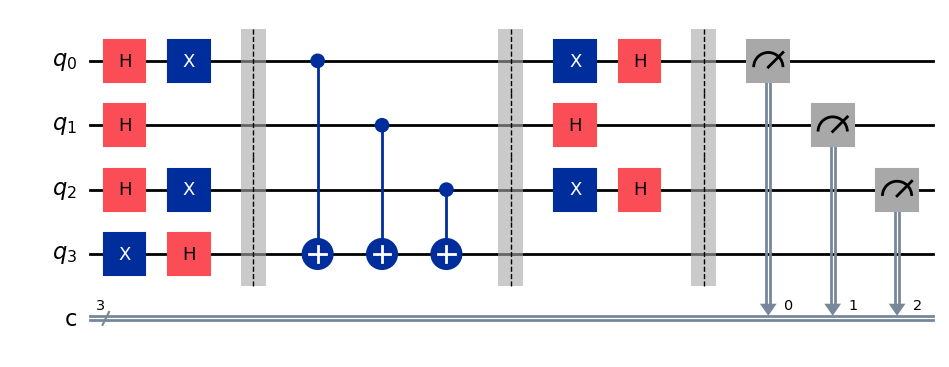

In [186]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit = dj_circuit.compose(balanced_oracle)

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw('mpl')

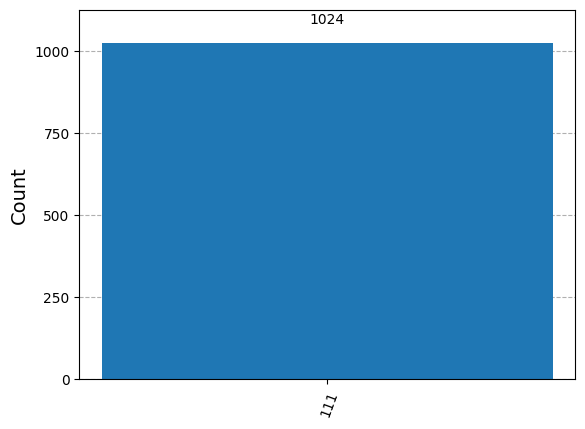

In [187]:
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(dj_circuit, simulator)
job1 = simulator.run(compiled_circuit, shots=1024)
result1 = job1.result()
counts1 = result1.get_counts(compiled_circuit)

pl1([counts1])

Grover's Algorithm

In [188]:
myList = [5,4,6,9,1,2,3,7,8,0]

In [189]:
def oracle(number):
    winningNumber = 8
    if number == winningNumber:
        response = True
    else:
        response = False
    return response

In [190]:
for index, number in enumerate(myList):
    if oracle(number) is True:
        print(f"winning number index: {index}")
        print(f"execution count: {index+1}")
        break

winning number index: 8
execution count: 9


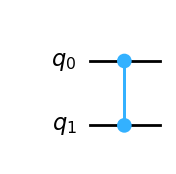

In [191]:
oracleCircuit = QuantumCircuit(2,name='oracleCircuit')
oracleCircuit.cz(0,1)
oracleCircuit.to_gate()
oracleCircuit.draw(output='mpl')

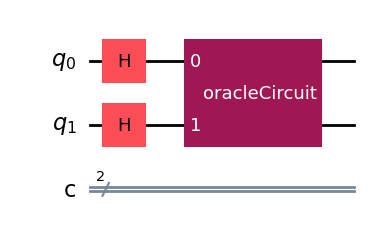

In [192]:
mainCircuit = QuantumCircuit(2,2)
mainCircuit.h([0,1])
mainCircuit.append(oracleCircuit,[0,1])
mainCircuit.draw(output='mpl')

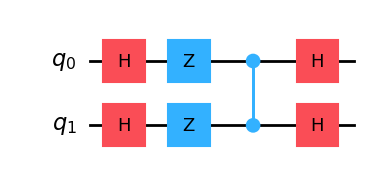

In [193]:
reflectionCircuit = QuantumCircuit(2,name="reflectionCircuit")
reflectionCircuit.h([0,1])
reflectionCircuit.z([0,1])
reflectionCircuit.cz(0,1)
reflectionCircuit.h([0,1])
reflectionCircuit.to_gate()
reflectionCircuit.draw(output='mpl')

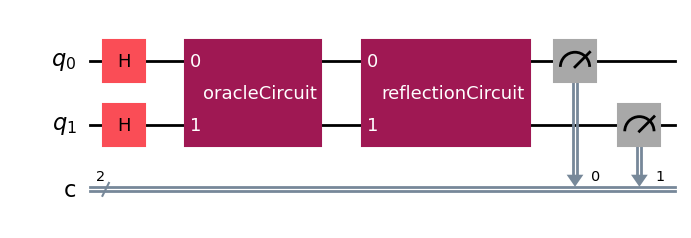

In [194]:
mainCircuit.append(reflectionCircuit,[0,1])
mainCircuit.measure([0,1],[0,1])
mainCircuit.draw(output='mpl')

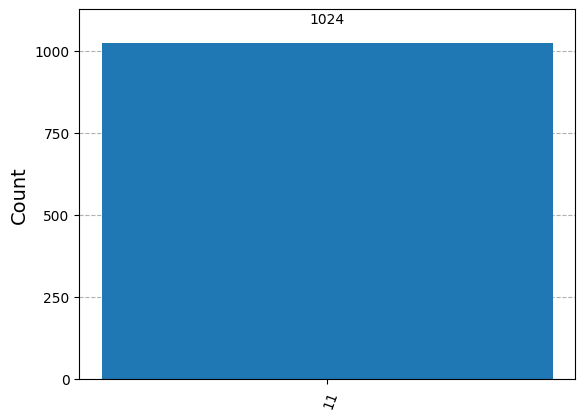

In [195]:
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(mainCircuit, simulator)
job2 = simulator.run(compiled_circuit, shots=1024)
result2 = job2.result()
counts2 = result2.get_counts(compiled_circuit)

pl1([counts2])

Shor's Algorithm

In [196]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [197]:
n_count = 8
a = 7

In [198]:
def qft_dagger(n):
    qc1 = QuantumCircuit(n)
    for qubit in range(n//2):
        qc1.swap(qubit,n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc1.cp(-np.pi/float(2**(j-m)),m,j)
        qc1.h(j)
    qc1.name = "QFT Dagger"
    return qc1

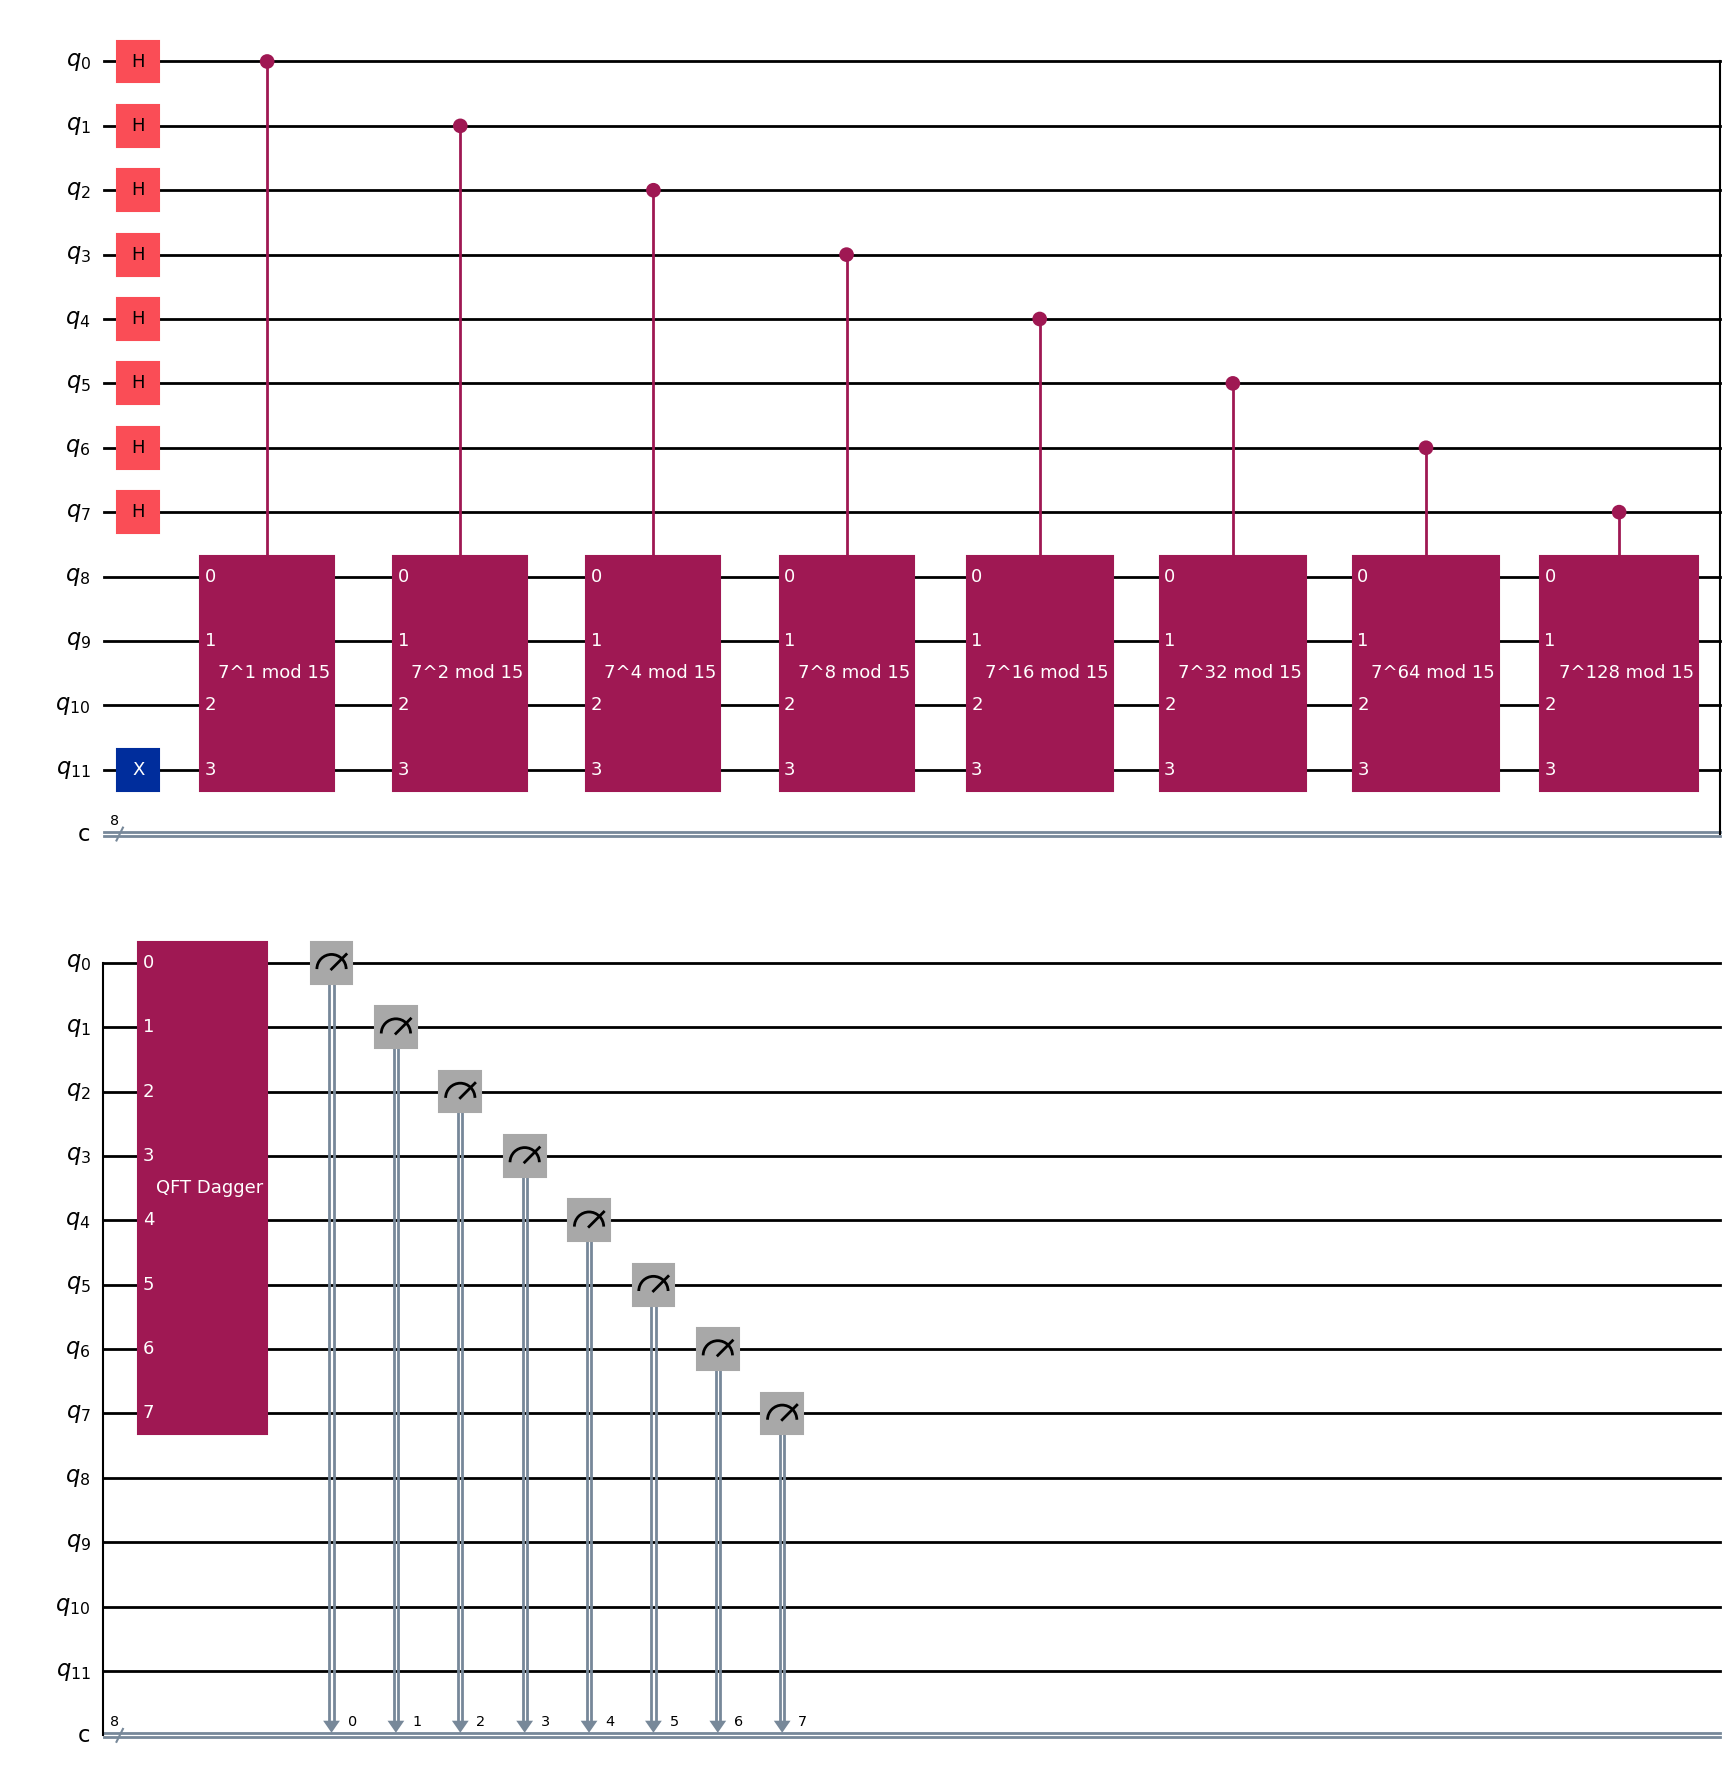

In [199]:
qc1 = QuantumCircuit(n_count + 4, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc1.h(q)
    
# And auxiliary register in state |1>
qc1.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc1.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc1.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc1.measure(range(n_count), range(n_count))

qc1.draw(output='mpl')

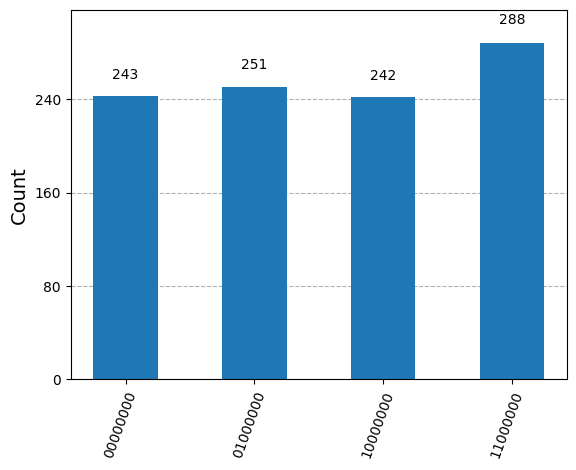

In [200]:
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc1, simulator)
job3 = simulator.run(compiled_circuit, shots=1024)
result3 = job3.result()
counts3 = result3.get_counts(compiled_circuit)

pl1([counts3])

Quantum Dense Coding

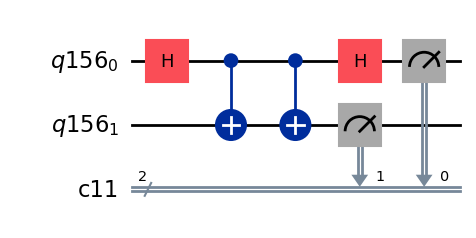

Message 00: {'01001': 1024}


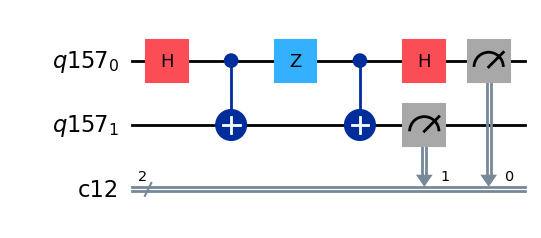

Message 01: {'01001': 1024}


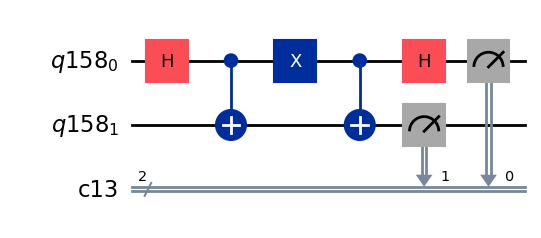

Message 10: {'01001': 1024}


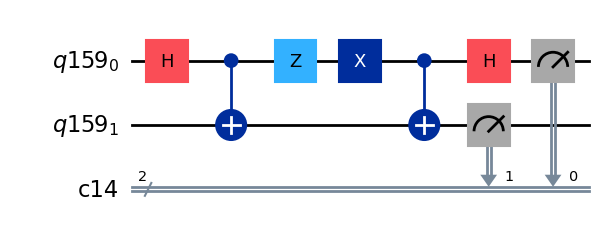

Message 11: {'01001': 1024}


In [201]:
def dense_coding(message):
    # Prepare quantum and classical registers
    qr = QuantumRegister(2)  # 2 qubits for Alice and Bob
    cr = ClassicalRegister(2) # 2 classical bits for measurement
    qc2 = QuantumCircuit(qr, cr)

    # Step 1: Create a Bell pair
    qc2.h(qr[0])       # Apply H gate on Alice's qubit
    qc2.cx(qr[0], qr[1])  # Apply CNOT (entangle Alice and Bob's qubits)

    # Step 2: Alice encodes the message
    if message == "00":
        pass            # No operation (identity)
    elif message == "01":
        qc2.z(qr[0])     # Apply Z gate
    elif message == "10":
        qc2.x(qr[0])     # Apply X gate
    elif message == "11":
        qc2.z(qr[0])     # Apply Z gate, then X gate
        qc2.x(qr[0])

    # Step 3: Alice sends her qubit to Bob (already implicit in Qiskit as they share qr[0] and qr[1])

    # Step 4: Bob decodes the message
    qc2.cx(qr[0], qr[1])  # Apply CNOT gate
    qc2.h(qr[0])          # Apply H gate

    # Step 5: Measure both qubits
    qc2.measure(qr, cr)

    # Execute the circuit on a simulator
    simulator = AerSimulator()
    compiled_circuit = transpile(qc2, simulator)
    job4 = simulator.run(compiled_circuit, shots=1)
    result4 = job4.result()
    counts4 = result4.get_counts(compiled_circuit)

    display(qc2.draw('mpl'))


    # Return the decoded message (expected to match original input)
    return counts

# Test the dense coding function with different messages
print("Message 00:", dense_coding("00"))
print("Message 01:", dense_coding("01"))
print("Message 10:", dense_coding("10"))
print("Message 11:", dense_coding("11"))


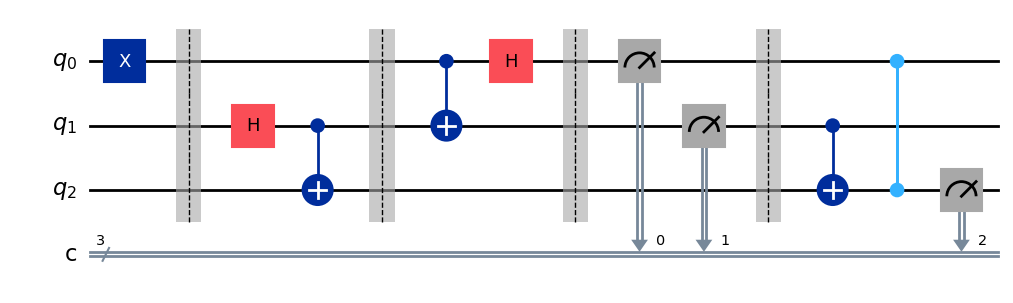

In [202]:
circuit = QuantumCircuit(3,3)

circuit.x(0) 

circuit.barrier() 

circuit.h(1)
circuit.cx(1,2)

circuit.barrier()

circuit.cx(0,1)
circuit.h(0)

circuit.barrier() 
circuit.measure([0, 1], [0, 1]) 

circuit.barrier() 

circuit.cx(1, 2)
circuit.cz(0, 2)

circuit.measure([2], [2])
circuit.draw('mpl')

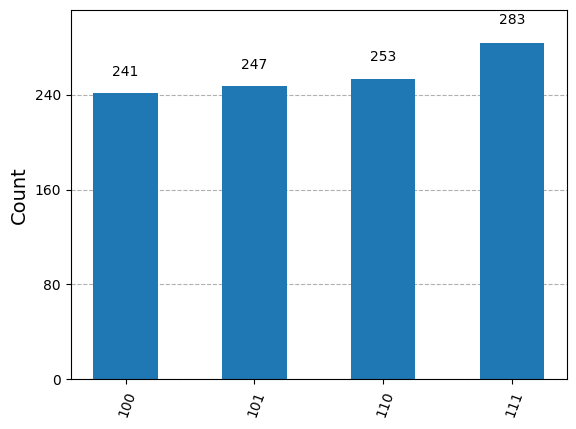

In [204]:
simulator = AerSimulator()
compiled_circuit = transpile(circuit, simulator)
job5 = simulator.run(compiled_circuit, shots=1024)
result5 = job5.result()
counts5 = result5.get_counts(compiled_circuit)
pl1([counts5])